<a href="https://colab.research.google.com/github/lanej5/mlb/blob/main/elo/elo_2022_07_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#notebook setup

In [65]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/My Drive/mlb/modelling/models")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load and prepare data

In [66]:
import pandas as pd
pd.set_option('display.max_columns', None)

features = pd.read_parquet(
    '/content/drive/My Drive/mlb/features/features.parquet',
    columns=['game_id', 'date', 'visitor_id', 'home_id', 'season', 'W'])

In [68]:
features.head(10)

,game_id,date,visitor_id,home_id,season,W
0,0,1990-04-09,5,2,1990,1
1,1,1990-04-09,11,0,1990,0
2,2,1990-04-09,23,3,1990,1
3,3,1990-04-09,8,10,1990,1
4,4,1990-04-09,14,13,1990,1
5,5,1990-04-09,18,6,1990,0
6,6,1990-04-09,21,20,1990,1
7,7,1990-04-09,26,24,1990,0
8,8,1990-04-09,29,28,1990,1
9,9,1990-04-10,29,28,1990,1


In [69]:
# note that the 2020 pandemic season had a low number of games
features.groupby('season')['game_id'].count()

season
1990    2096
1991    2095
1992    2097
1993    2260
1994    1593
1995    2008
1996    2258
1997    2257
1998    2419
1999    2415
2000    2416
2001    2416
2002    2413
2003    2417
2004    2415
2005    2418
2006    2416
2007    2418
2008    2415
2009    2417
2010    2417
2011    2416
2012    2417
2013    2418
2014    2417
2015    2416
2016    2415
2017    2417
2018    2418
2019    2416
2020     894
2021    2416
Name: game_id, dtype: int64

In [71]:
# teams are indexed 0 - 29
# (teams that changed name between seasons, e.g. MON -> WAS, are considered the same)
assert set(features['home_id'].to_list()) == {n for n in range(30)}

# model code

In [72]:
# model.py
"""Define Model abstract base class and Forecast module."""
from typing import List, Dict
from abc import ABC, abstractmethod
from dataclasses import dataclass

from utils import save_parameters


@dataclass
class Game():
  """Representation of games."""
  home: str
  visitor: str


class Model(ABC):
  """Model abstract base class.

  Represents a model that predicts win probabilities
  for individual games and has an online learning
  algorithm (implemented by step).
  """
  @abstractmethod
  def predict_proba(self, game: Game) -> float:
    """Predict probability that home team wins."""
    pass

  @abstractmethod
  def step(self, game: Game, result: float) -> None:
    """Perform single step parameter update."""
    pass

  def save_parameters(self, bucket_name: str, params: Dict) -> None:
    """Save model parameters."""
    save_parameters(bucket_name, params)

  def train(self, schedule: List[Game], results: List[float]) -> None:
    """Train the model with game results."""
    for game, result in zip(schedule, results):
      self.step(game, result)

In [85]:
# elo.py
"""Simple ELO model."""
import os
from typing import Dict
from dataclasses import dataclass

# from model import Model, Game
from utils import sigmoid, load_parameters


@dataclass
class ELOParams():
  """Parameters for the ELO model."""
  rating: List[float]
  a: float
  k: float
  b: float


class ELO(Model):
  """Simple Elo Model.

  Logistic regression model for Bradley-Terry paired comparison of teams.

  Model Parameters:
    a: scaling factor.
    b: y-intercept.
    ratings: regression coefficients.
    k: learning rate.

  Note: the coefficient b is not learnable in this model.
  """
  def __init__(self, bucket_name: str=None):
    if bucket_name is not None:
      self.params = load_parameters(bucket_name)
    else:
      self.params = None

  @classmethod
  def from_ELOParams(cls, params: ELOParams):
    model = cls(None)
    model.params = params
    return model

  def predict_proba(self, game: Game) -> float:
    """Predict probability that home team wins."""
    logit = self.params.a * (self.params.rating[game.home] - self.params.rating[game.visitor]) + self.params.b
    return sigmoid(logit)

  def step(self, game: Game, result: float) -> None:
    """Perform a single step of SGD."""
    p = self.predict_proba(game)
    self.params.rating[game.home] += self.params.k * (result - p)
    self.params.rating[game.visitor] += self.params.k * (p - result)

  def reset_weights(self):
    self.params.rating = 30 * [0]


In [86]:
# basic test for functionality
params = ELOParams(**{
    'a': 1,
    'k': 2,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_ELOParams(params)

g = Game(**{'home': 0, 'visitor': 1})
print(elo.predict_proba(g))
elo.step(g, 1)

print(elo.params)

elo.reset_weights()

print(elo.params)

0.5374298453437496
ELOParams(rating=[0.9251403093125008, -0.9251403093125008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], a=1, k=2, b=0.15)
ELOParams(rating=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], a=1, k=2, b=0.15)


# hyperparameter selection

In [178]:
from pandas.core.dtypes.cast import sanitize_to_nanoseconds
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def train(model, features, reset_yearly=True):
    cols = features.columns.to_list() + ['p', 'home_rating', 'visitor_rating']
    df = pd.DataFrame(columns=cols)
    df[features.columns] = features
    current_season = features.loc[0, 'season']
    results = []

    for i in range(len(df)):
        if df.loc[i, 'season'] > current_season and reset_yearly:
            model.reset_weights()
            current_season = df.loc[i, 'season']

        h, v = df.loc[i, 'home_id'], df.loc[i, 'visitor_id']
        g = Game(h, v)
        p = model.predict_proba(g)
        model.step(g, df.loc[i, 'W'])

        # log values
        h_rating = model.params.rating[h]
        v_rating = model.params.rating[v]

        results.append((p, h_rating, v_rating))
    
    df[['p', 'home_rating', 'visitor_rating']] = results

    df['log_loss'] = - df['W'] * np.log(df['p']) - (1 - df['W']) * np.log(1 - df['p'])

    return df

def plot_model_performance(df):

    ll = - df.groupby('season')['log_loss'].mean()

    seasons = list(set(df['season'].to_list()))

    auc = [roc_auc_score(df.loc[df['season'] == s, 'W'], df.loc[df['season'] == s,'p']) for s in seasons]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax1 = ax.twinx()

    ax.plot(seasons, auc, 'C0-')
    ax1.plot(seasons, ll, 'C1-')

    ax.set_xlabel('season')
    ax.set_ylabel('auc', color='C0')
    ax1.set_ylabel('negative log loss', color='C1')
    ax1.grid(False)

    avg_ll = -df['log_loss'].mean()
    total_auc = roc_auc_score(df['W'], df['p'])
    ax.set_title(f'Model performance by season (avg_log_loss = {avg_ll:.2f}, roc_auc = {total_auc:.2f})')
    plt.show()
    pass

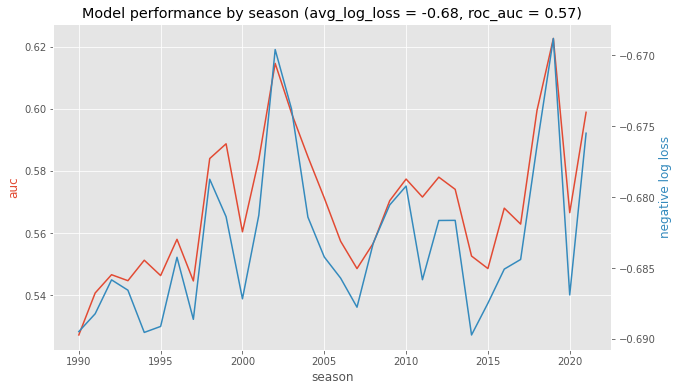

In [179]:
params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_ELOParams(params)

df = train(elo, features, False)

plot_model_performance(df)

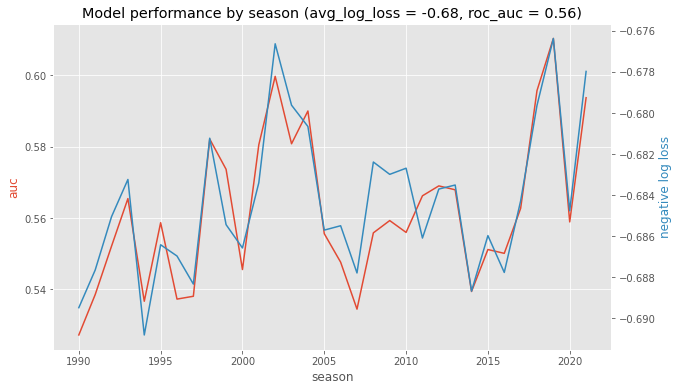

In [180]:
params = ELOParams(**{
    'a': log(10) / 400,
    'k': 4,
    'b': 0.15,
    'rating': 30 * [0]
})

elo = ELO.from_ELOParams(params)

df = train(elo, features)

plot_model_performance(df)

In [181]:
df

,game_id,date,visitor_id,home_id,season,W,p,home_rating,visitor_rating,log_loss
0,0,1990-04-09,5,2,1990,1,0.537430,1.850281,-1.850281,0.620957
1,1,1990-04-09,11,0,1990,0,0.537430,-2.149719,2.149719,0.770957
2,2,1990-04-09,23,3,1990,1,0.537430,1.850281,-1.850281,0.620957
3,3,1990-04-09,8,10,1990,1,0.537430,1.850281,-1.850281,0.620957
4,4,1990-04-09,14,13,1990,1,0.537430,1.850281,-1.850281,0.620957
...,...,...,...,...,...,...,...,...,...,...
73131,73131,2021-10-03,23,20,2021,1,0.587366,70.860178,32.279143,0.532107
73132,73132,2021-10-03,19,15,2021,1,0.446861,-70.205845,-11.508336,0.805508
73133,73133,2021-10-03,4,13,2021,0,0.474472,-54.009667,-6.402156,0.643352
73134,73134,2021-10-03,17,28,2021,0,0.631066,29.649381,-32.494827,0.997137
